# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [196]:
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [198]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [199]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=2000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

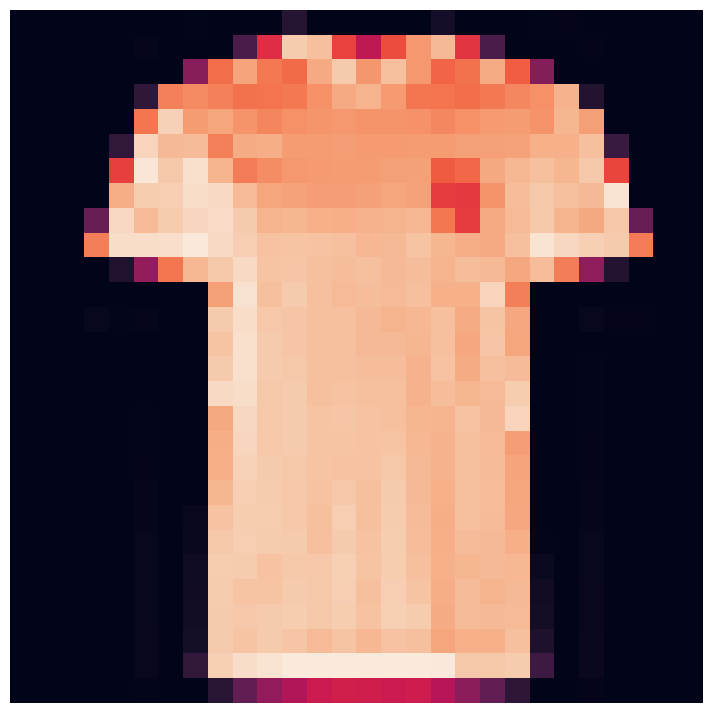

In [200]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off")
plt.show()

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

Какие есть классы:

In [201]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

 Выбираю по одной картинке

In [202]:
class_examples = {}
images = {}
for i in range(10):
    class_examples[f"class_{i}"] = np.where(y == f"{i}")[0][0]
    images[f"image_{i}"] = X[class_examples[f"class_{i}"]].reshape(28,28,1)

Черчу

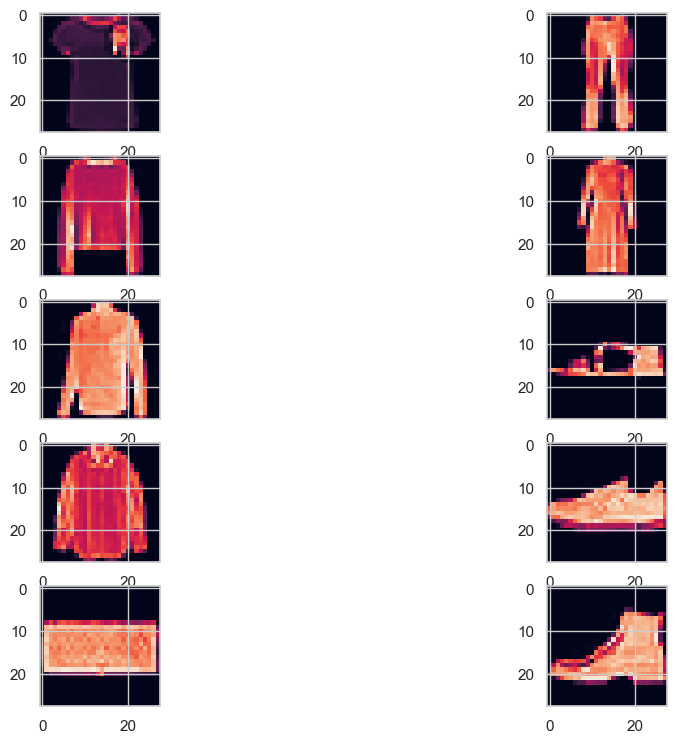

In [203]:
fig, axes = plt.subplots(nrows = 5, ncols = 2)
for i in range(5):
    for j in range(2):
        axes[i,j].imshow(images[f"image_{2*i + j}"])
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

Смотрю на баланс классов в процентах

In [204]:
classes = np.unique(y, return_counts=True) 
balance = classes[1] / np.sum(classes[1]) * 100 
balance

array([ 9.3 , 10.45, 10.65, 10.3 ,  9.85, 10.25, 10.3 ,  8.9 , 10.2 ,
        9.8 ])

Дополнительно посмотрю на разброс

In [205]:
np.mean(balance), np.std(balance)

(10.0, 0.5167204273105521)

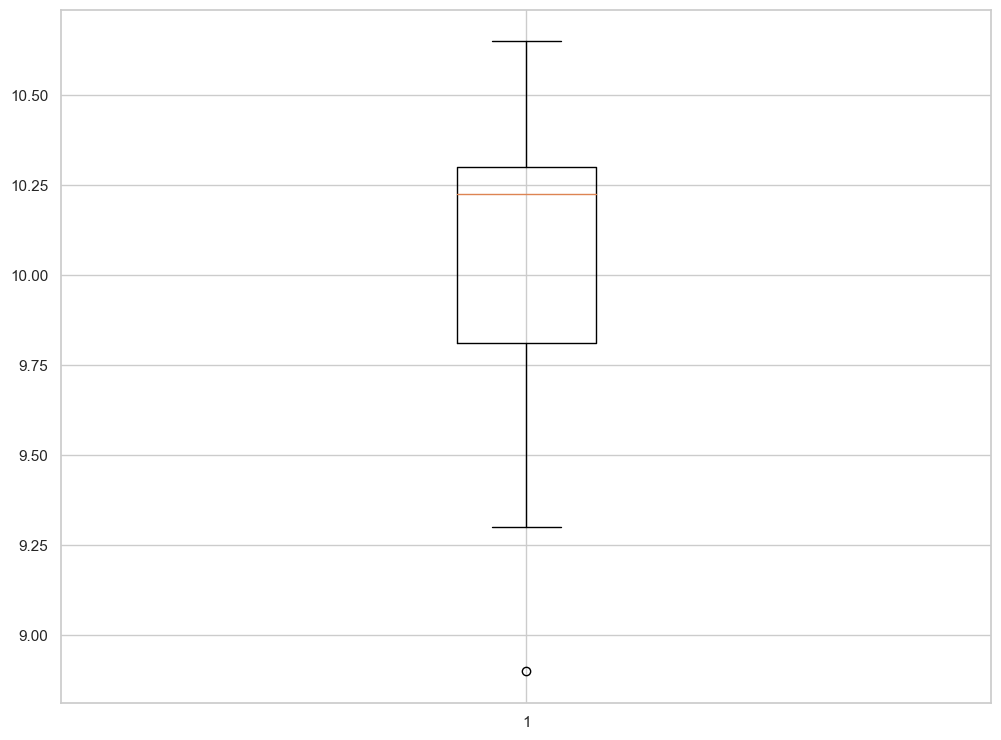

In [206]:
plt.boxplot(balance)
plt.show()

По мне всё хорошо

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

По умолчанию возьму в тренировочную выборку 20%, а там видно будет. Но в целом размеры 200 и 800 для меня выглядят нормально

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [208]:
binary_train_y = y_train[(y_train == "0") | (y_train == "1")]
binary_test_y = y_test[(y_test == "0") | (y_test == "1")]

In [209]:
train_pos = np.where((y_train == "0") | (y_train == "1"))[0]
test_pos = np.where((y_test == "0") | (y_test == "1"))[0]

In [210]:
binary_train_X = X_train[train_pos]
binary_test_X = X_test[test_pos]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [211]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [212]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Я тут оставлю продублированную "ручную" функцию, у меня почему-то через метод не работало, с помощью функции ниже как раз и починил метод. Да и проверять так удобнее, можно не ходить в Knn.py, а сразу тут посмотреть

In [138]:
def compute_distances_two_loops(train_X, X):
    distances = np.zeros(X.shape[0] * train_X.shape[0]).reshape(X.shape[0], train_X.shape[0])
    for i in np.arange(X.shape[0]):
        for j in np.arange(train_X.shape[0]):
            distances[i, j] = np.sum(np.absolute(X[i] - train_X[j]))
    return distances

dists = compute_distances_two_loops(binary_train_X, binary_test_X)

In [215]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Аналогчно приведу здесь код в виде функции

In [19]:
def compute_distances_one_loop(train_X, X):   
    distances = np.zeros(X.shape[0] * train_X.shape[0]).reshape(X.shape[0], train_X.shape[0])
    for i in np.arange(X.shape[0]):
        future_row = np.absolute(X[i] - train_X)
        distances[i] = future_row.sum(axis = 1)
    return distances

In [214]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Вот так же функция, но я до этого сам не додумался, мне подсказали

In [260]:
def compute_distances_no_loops(train_X, X):
    distances = np.sum(np.abs(X[:, np.newaxis]-train_X), axis=2)
    return distances

И ещё вариант (тоже не мой, я слишком сложно решал)

In [262]:
def compute_distances_no_loops(train_X, X):
    distances = np.array([np.sum(np.abs(x-self.train_X), axis=1) for x in X])
    return distances

Проверим скорость работы реализованных методов

In [216]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

456 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
85 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
262 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Реализуем метод для предсказания меток класса

In [217]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [218]:
binary_test_y

array(['1', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1',
       '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0',
       '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1',
       '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0'],
      dtype=object)

In [219]:
prediction

array(['1', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1',
       '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0',
       '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1',
       '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0'],
      dtype='<U32')

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [ ]:
# TODO: binary_classification_metrics in metrics.py

In [220]:
binary_classification_metrics(prediction, binary_test_y)


(0.9791666666666666, 1.0, 0.9894736842105264, 0.9888888888888889)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [221]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [222]:
precision_score(binary_test_y.astype(int), prediction.astype(int))

0.9791666666666666

In [223]:
recall_score(binary_test_y.astype(int), prediction.astype(int))

1.0

In [224]:
f1_score(binary_test_y.astype(int), prediction.astype(int))

0.9894736842105264

In [225]:
accuracy_score(binary_test_y.astype(int), prediction.astype(int))

0.9888888888888889

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

Выбираю accuracy, так как в целом нам важно правильно определять тот или иной тип одежды, поэтому FN и FP тут равнозначны

In [226]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    metrics_train = {"accuracy_score": [],
                     "precision_score": [],
                     "recall_score": [],
                     "f1_score":[]}
    
    
    metrics_test = {"accuracy_score": [],
                    "precision_score":[],
                    "recall_score": [],
                    "f1_score":[]}
    
    for i in range(len(params)):
        knn_classifier_temp = KNNClassifier(k=params[i])
        knn_classifier_temp.fit(X_train, y_train)
        
        dists_train = knn_classifier_temp.compute_distances_one_loop(X_train)
        prediction_train = knn_classifier_temp.predict(X_train)
        
        ac_tr, pr_tr, rc_tr, f_tr = binary_classification_metrics(prediction_train, y_train)
        
        metrics_train_loc = {"accuracy_score": ac_tr,
                        "precision_score":pr_tr,
                        "recall_score": rc_tr,
                        "f1_score":f_tr}
        
        metrics_train[metric].append(metrics_train_loc[metric])
        
        
        dists_test = knn_classifier_temp.compute_distances_one_loop(X_test)
        prediction_test = knn_classifier_temp.predict(X_test)
        
        ac_tt, pr_tt, rc_tt, f_tt = binary_classification_metrics(prediction_test, y_test)
        
        metrics_test_loc = {"accuracy_score": ac_tt,
                        "precision_score":pr_tt,
                        "recall_score": rc_tt,
                        "f1_score":f_tt}
        
        metrics_test[metric].append(metrics_test_loc[metric])
        
        
    return  metrics_train[metric], metrics_test[metric]

In [227]:
params = [1, 2, 4, 5, 8, 10, 30] #[i for i in range(150)] 
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "accuracy_score")

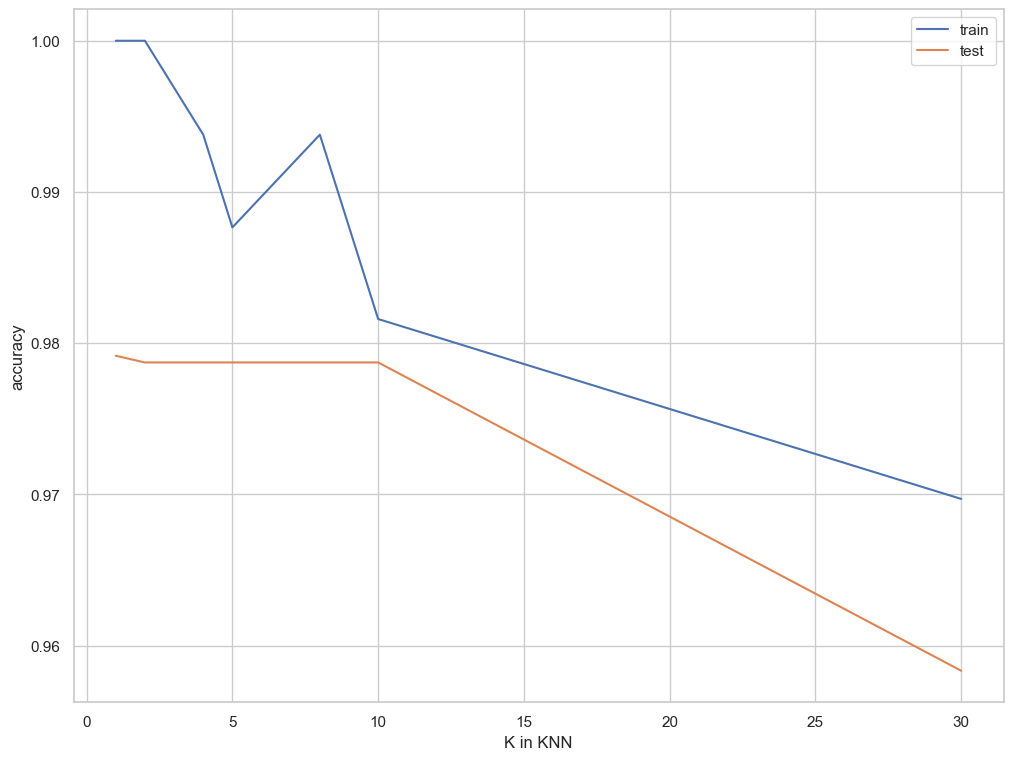

In [228]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy")
plt.show()

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

Немного изменю функцию для метрик и положу сюда для ручной работы

In [229]:
def class_metrics(y_pred, y_true):
    y_pred = np.array(y_pred.astype(int).astype(str), dtype = object)
    codes = y_true + y_pred
    TP = np.sum(np.where(codes == "11"))
    TN = np.sum( (codes == "00").astype(int) )
    FP = np.sum( (codes == "01").astype(int) )
    FN = np.sum( (codes == "10").astype(int) )
    accuracy_0 = 0 if FP == 0. else FP/(FP+FN)
    accuracy_1 = 0 if TP == 0 else TP/(TP+FP)
    return accuracy_0, accuracy_1

Выбираю k = 10

In [230]:
knn_classifier_temp = KNNClassifier(k=10)
knn_classifier_temp.fit(binary_train_X, binary_train_y)
dists_test = knn_classifier_temp.compute_distances_one_loop(binary_test_X)
prediction_test = knn_classifier_temp.predict(binary_test_X)
Accuracies = class_metrics(prediction_test, binary_test_y)
print(f"0 class - {Accuracies[0]}",f"1 class - {Accuracies[1]}", sep = "\n" )

0 class - 0.5
1 class - 0.999465811965812


 Судя по данным, 0 предсказывает хуже

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [231]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
knn_classifier.compute_distances_one_loop(X_test)
predictions = knn_classifier.predict(X_test)

In [232]:
predictions 

array(['9', '7', '1', '6', '1', '8', '8', '8', '9', '9', '3', '1', '2',
       '5', '3', '7', '0', '9', '3', '6', '8', '5', '1', '8', '6', '9',
       '2', '3', '6', '8', '6', '8', '8', '4', '8', '5', '4', '9', '9',
       '9', '8', '8', '4', '3', '9', '2', '1', '4', '8', '8', '0', '1',
       '7', '7', '0', '6', '8', '6', '4', '6', '2', '2', '3', '5', '9',
       '8', '4', '6', '1', '3', '0', '3', '1', '7', '5', '6', '1', '2',
       '5', '7', '2', '4', '7', '7', '4', '6', '8', '6', '5', '5', '5',
       '9', '7', '1', '1', '0', '7', '2', '6', '2', '6', '6', '7', '3',
       '0', '8', '1', '1', '0', '6', '6', '1', '5', '4', '3', '7', '9',
       '8', '3', '0', '2', '8', '2', '1', '2', '3', '0', '3', '7', '6',
       '5', '9', '2', '9', '1', '1', '5', '0', '1', '9', '2', '4', '6',
       '8', '1', '1', '9', '8', '1', '6', '7', '1', '4', '6', '3', '1',
       '7', '7', '4', '6', '1', '3', '1', '5', '6', '7', '9', '5', '6',
       '9', '8', '4', '5', '3', '6', '3', '4', '1', '7', '6', '8

In [233]:
y_test

array(['9', '7', '1', '0', '1', '8', '8', '8', '9', '7', '3', '1', '0',
       '5', '3', '7', '0', '5', '0', '2', '8', '5', '1', '8', '4', '9',
       '6', '3', '2', '8', '6', '8', '8', '4', '8', '5', '3', '7', '9',
       '9', '8', '8', '6', '3', '9', '2', '1', '6', '8', '8', '6', '1',
       '7', '7', '0', '2', '8', '2', '2', '6', '0', '6', '3', '5', '9',
       '8', '4', '6', '1', '3', '0', '0', '1', '7', '5', '6', '1', '2',
       '5', '7', '2', '4', '7', '5', '4', '6', '8', '8', '5', '5', '5',
       '9', '7', '1', '1', '0', '7', '4', '6', '4', '6', '4', '7', '3',
       '0', '8', '1', '1', '0', '8', '2', '1', '5', '4', '3', '7', '9',
       '8', '0', '0', '6', '8', '4', '1', '2', '3', '6', '3', '7', '6',
       '5', '9', '2', '9', '1', '1', '5', '6', '1', '9', '6', '4', '2',
       '8', '1', '1', '9', '8', '1', '6', '7', '1', '4', '6', '3', '1',
       '7', '9', '4', '2', '1', '3', '1', '5', '6', '7', '5', '5', '4',
       '9', '8', '4', '5', '3', '2', '3', '2', '1', '7', '6', '8

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [234]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.77

Обработать тренировочные данные мне не удаётся из-за ограниченности ресурсов компа, поэтому буду смотреть только тестовые

In [236]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    
    accuracy_test = []  
    
    for i in range(len(params)):
        
        knn_classifier_temp = KNNClassifier(k=params[i])
        knn_classifier_temp.fit(X_train, y_train)
        
        dists_test = knn_classifier_temp.compute_distances_one_loop(X_test)
        prediction_test = knn_classifier_temp.predict(X_test)
        
        ac_tt = multiclass_accuracy(prediction_test, y_test)
        
        accuracy_test.append(ac_tt)
        
        print(f"{i} passed")
        
    return  accuracy_test

In [237]:
params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 30] #[i for i in range(150)] 
test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score)

0 passed
1 passed
2 passed
3 passed
4 passed
5 passed
6 passed
7 passed
8 passed
9 passed
10 passed
11 passed
12 passed
13 passed
14 passed
15 passed


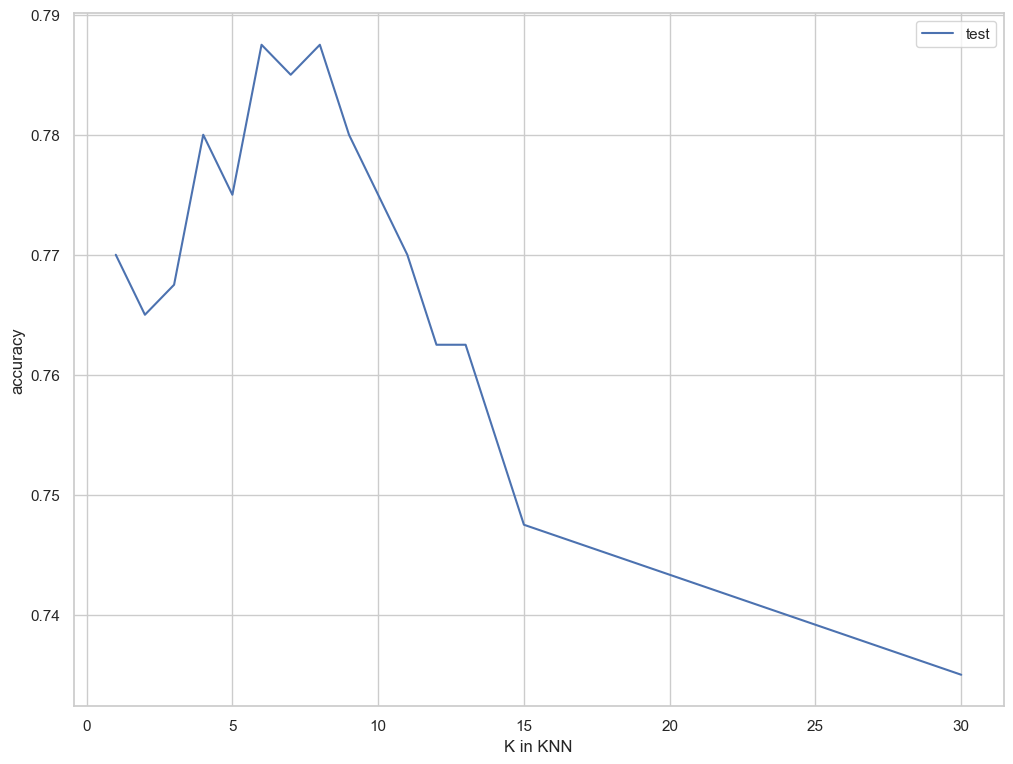

In [238]:
#plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("accuracy")
plt.show()

Здесь оптимум более ярко выражен в сравнении с бинарной классификацией. Возьму k = 8

In [239]:
def multi_class_metrics(y_pred, y_true):
    y_pred = np.array(y_pred.astype(int).astype(str), dtype=object)
    codes = y_pred + y_true
    al = codes.shape[0]
    procents = []
    for i in range(10):
        temp_TP = np.sum((codes == f"{i}"+f"{i}").astype(int))
        temp_al = 0
        for j in range(10):
            temp_al += np.sum((codes == f"{i}" + f"{j}").astype(int))
        procents.append(temp_TP / temp_al)
    print(f"0:  {procents[0]}", 
          f"1:  {procents[1]}",
          f"2:  {procents[2]}",
          f"3:  {procents[3]}",
          f"4:  {procents[4]}",
          f"5:  {procents[5]}",
          f"6:  {procents[6]}",
          f"7:  {procents[7]}",
          f"8:  {procents[8]}",
          f"9:  {procents[9]}", sep = "\n")
    return 

In [240]:
knn_classifier = KNNClassifier(k=8)
knn_classifier.fit(X_train, y_train)
knn_classifier.compute_distances_one_loop(X_test)
predictions = knn_classifier.predict(X_test)
multi_class_metrics(predictions, y_test)

0:  0.6923076923076923
1:  0.9767441860465116
2:  0.6222222222222222
3:  0.7297297297297297
4:  0.6842105263157895
5:  1.0
6:  0.55
7:  0.8484848484848485
8:  1.0
9:  0.8571428571428571


Класс 6 распознаётся хуже всего. Насколько я понял, это штаны

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [241]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [242]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [243]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [245]:
X.mean(), X.std()

(age   -3.639623e-16
 sex    1.309912e-16
 bmi   -8.013951e-16
 bp     1.289818e-16
 s1    -9.042540e-17
 s2     1.301121e-16
 s3    -4.563971e-16
 s4     3.863174e-16
 s5    -3.848103e-16
 s6    -3.398488e-16
 dtype: float64,
 age    0.047619
 sex    0.047619
 bmi    0.047619
 bp     0.047619
 s1     0.047619
 s2     0.047619
 s3     0.047619
 s4     0.047619
 s5     0.047619
 s6     0.047619
 dtype: float64)

Все средние равны нулю, а дисперсия вообще одинакова. Насколько я понял, именно факт близкой по значению дисерсии даёт нам возможность здесь безопасно применить стандартизацию. Но в данном случае она не нужна, так как дисперсия прям одинаковая. Взглянем также на распределение признаков

In [246]:
vars = X.columns

In [247]:
vars

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

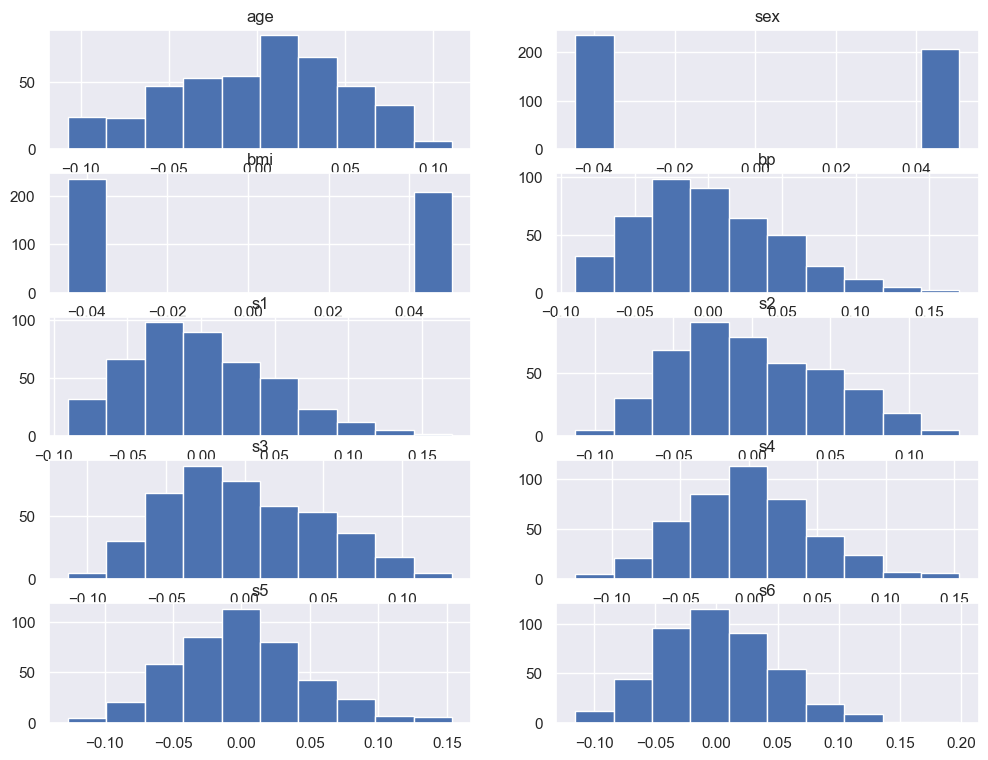

In [248]:
sns.set()
fig, axes = plt.subplots(nrows = 5, ncols = 2)
for i in range(5):
    for j in range(2):
        axes[i,j].hist(X[vars[i+j]])
        axes[i,j].title.set_text(vars[2*i+j])
plt.show()

Численные признаки распределены нормально, поэтому при будущей регрессии в целом можно будет использовать среднее, а не медиану (правильно?)

Посмотрим также выбросы

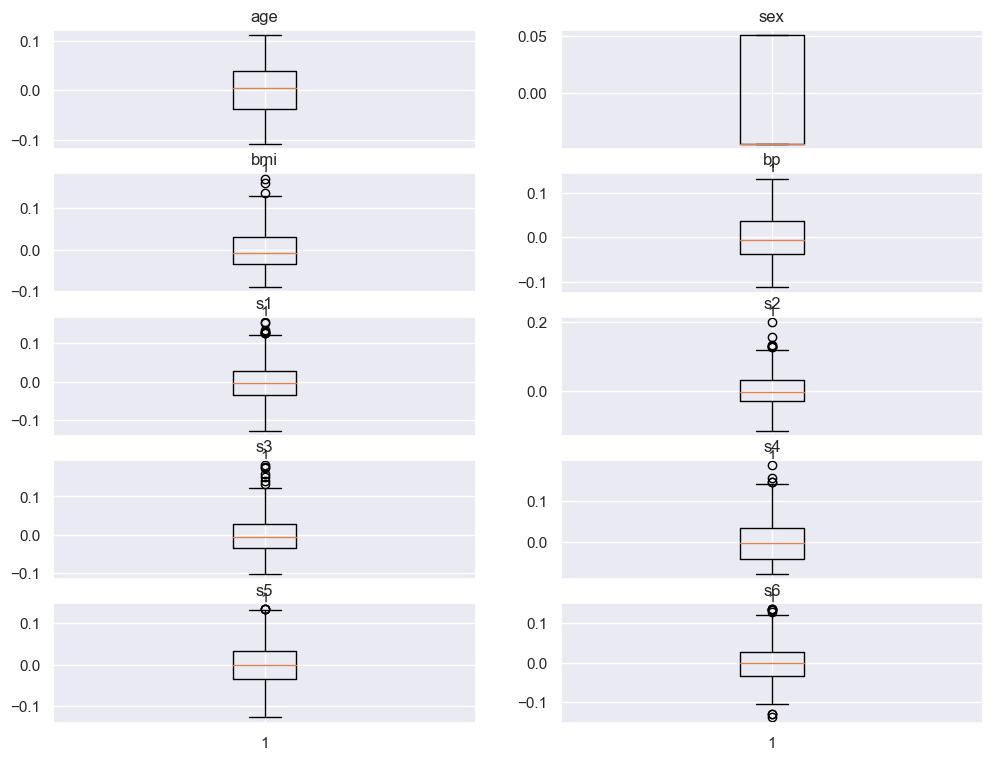

In [249]:
fig, axes = plt.subplots(nrows = 5, ncols = 2)
for i in range(5):
    for j in range(2):
        axes[i,j].boxplot(X[vars[2*i+j]])
        axes[i,j].title.set_text(vars[2*i+j])
plt.show()

Каких-то серьёзных выбросов нет

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = SEED)

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [251]:
from sklearn.neighbors import KNeighborsRegressor

In [252]:
knn_Regressor = KNeighborsRegressor()

In [253]:
knn_Regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [254]:
prediction = knn_Regressor.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [255]:
from metrics import r_squared, mse, mae
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [256]:
r_squared(prediction, y_test)

0.3518911884910063

In [257]:
r2_score(y_test, prediction)

0.3518911884910063

In [258]:
mse(prediction, y_test)

3046.400898876404

In [259]:
mean_squared_error(y_test, prediction)

3046.400898876404

In [260]:
mae(prediction, y_test)

41.11910112359551

In [261]:
mean_absolute_error(y_test, prediction)

41.11910112359551

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше. 

Эту функцию каждый раз приходится переписывать под текущие нужды

In [289]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    metrics_train = {"r_sq": [],
                    "mse": [],
                    "mae": []}
    
    metrics_test = {"r_sq": [],
                    "mse": [],
                    "mae": []}
    
    metric_functions = {"r_sq": r_squared,
                        "mse": mse,
                        "mae": mae}
    
    for i in range(len(params)):
        
        knn_Regressor_temp = KNeighborsRegressor(n_neighbors = params[i])
        knn_Regressor_temp.fit(X_train, y_train)
        prediction = knn_Regressor_temp.predict(X_train)
        
        loc_train = metric_functions[metric](prediction, y_train)
        metrics_train[metric].append(loc_train)
        
        prediction = knn_Regressor_temp.predict(X_test)
        
        loc_test =  metric_functions[metric](prediction, y_test)
        metrics_test[metric].append(loc_test)
        
        
    return  metrics_train[metric], metrics_test[metric]

In [290]:
params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 30] 
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, "r_sq")

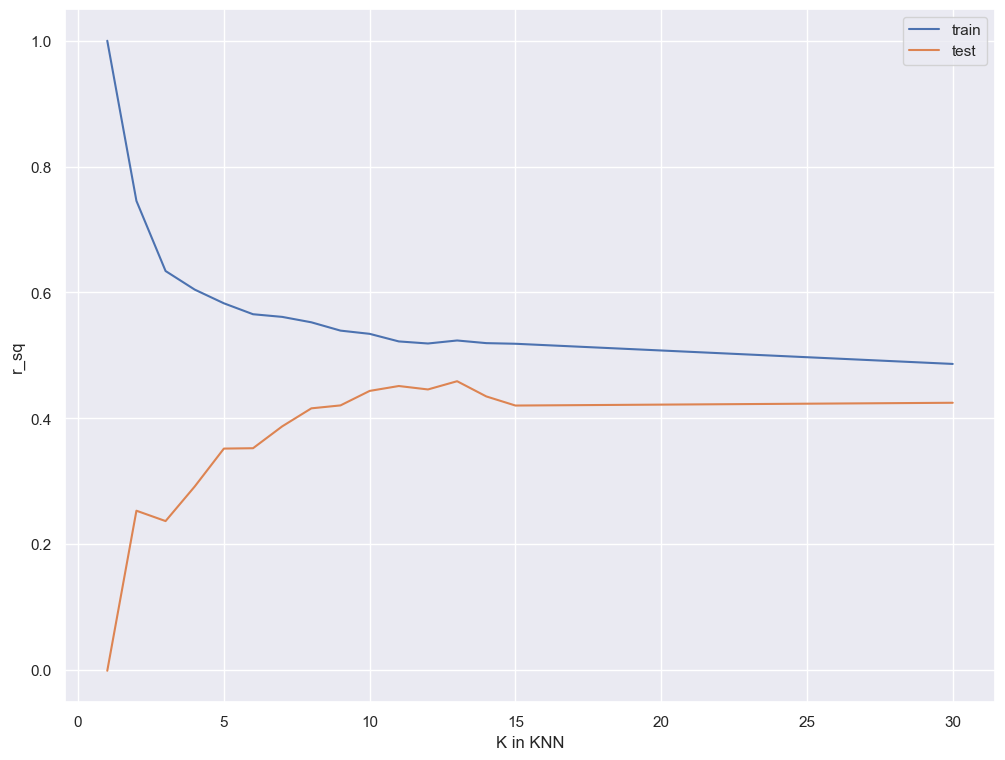

In [291]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("r_sq")
plt.show()

Выбираю K = 13

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

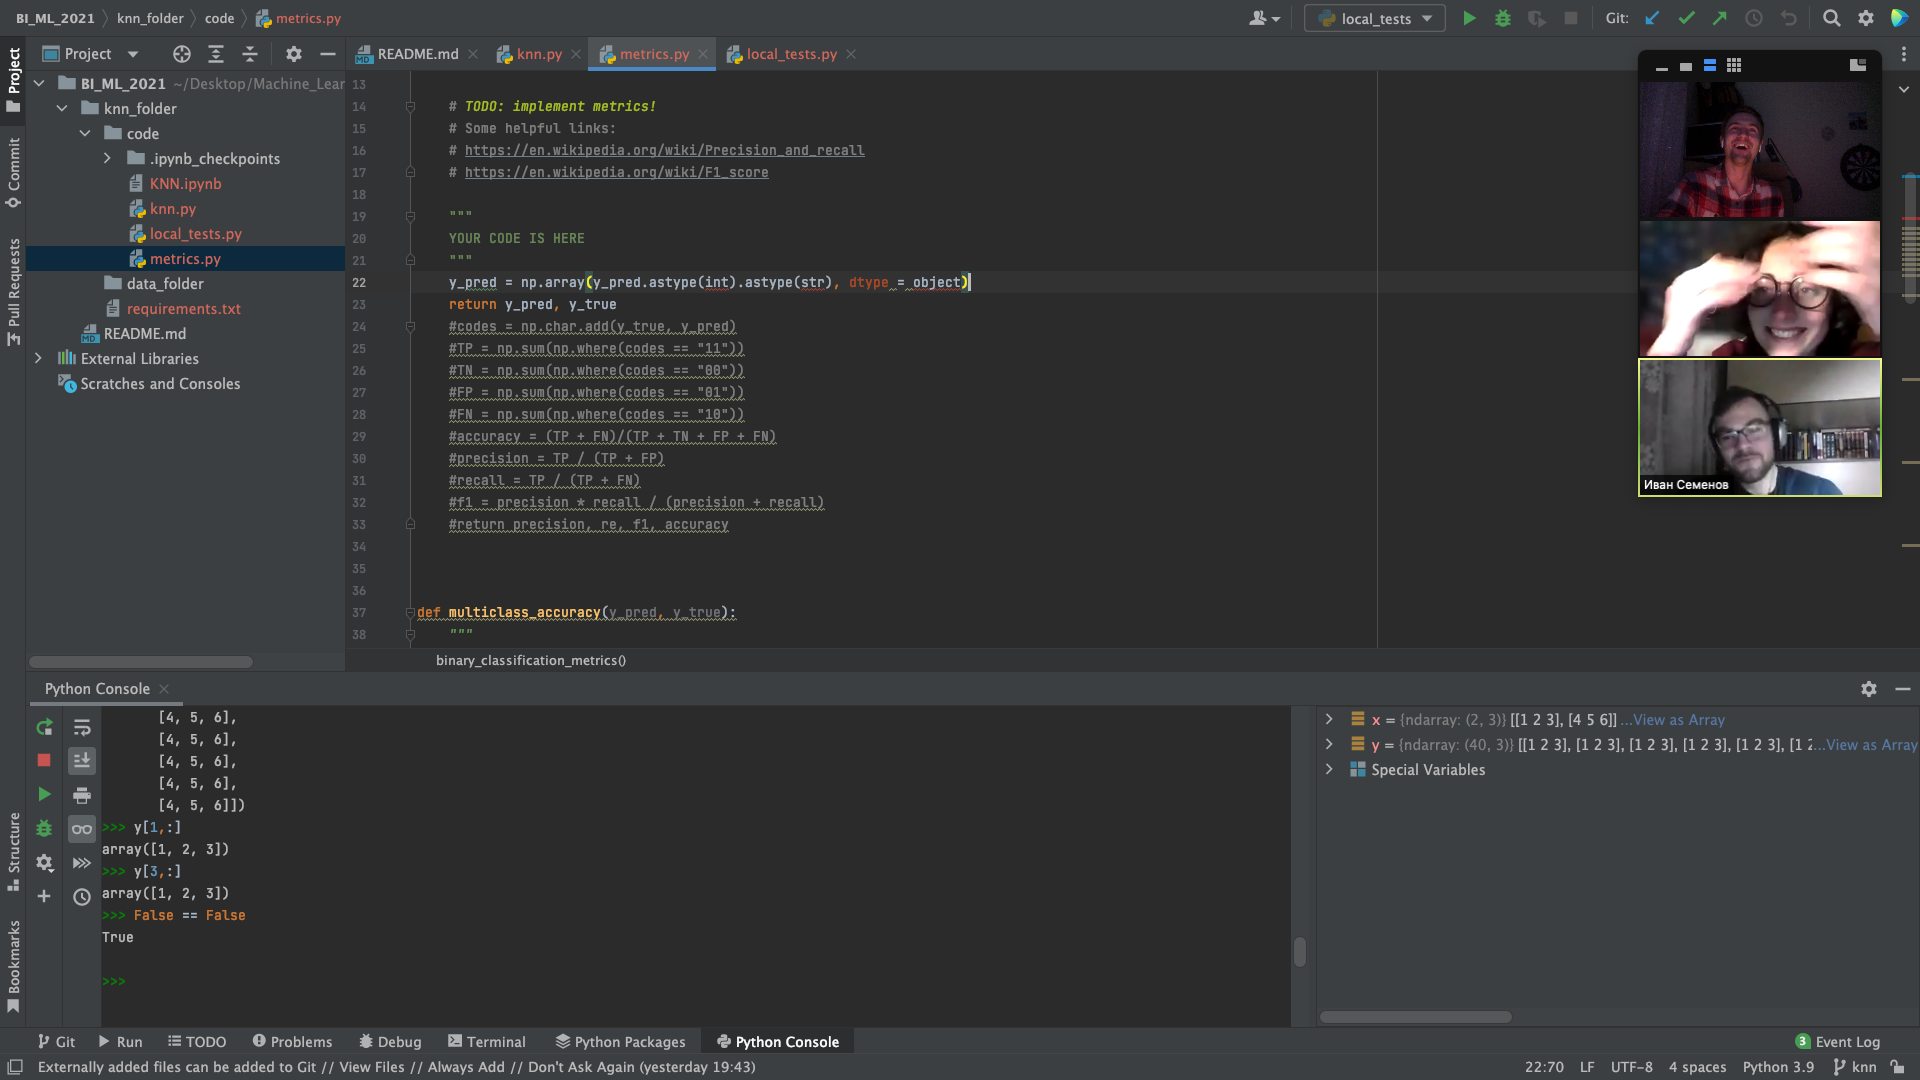

In [296]:
from IPython.display import Image
Image("../data_folder/Zoom.png")

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:** я поздновато приступил, а так было классно. Было очень тяжело придумать no_loop способ вычисления матрицы расстояний, я его так и не придумал, мне помогли